In [1]:
import pandas as pd

from src.storage.tables import AzureBlobTable
from src.utils.config import Config as cfg


train = AzureBlobTable(cfg.AZURE_PROCESSED_TABLE).download(["train"], concat=True)
test = AzureBlobTable(cfg.AZURE_PROCESSED_TABLE).download(["test"], concat=True)
valid = AzureBlobTable(cfg.AZURE_PROCESSED_TABLE).download(["valid"], concat=True)

train["F_DATE"] = pd.to_datetime(train["F_DATE"])
test["F_DATE"] = pd.to_datetime(test["F_DATE"])
valid["F_DATE"] = pd.to_datetime(valid["F_DATE"])

train

2022-11-08 22:05:02.668733 read: processed/train.csv <src.storage.tables.AzureBlobTable object at 0x000001B9631234F0>
2022-11-08 22:05:04.119611 read: processed/test.csv <src.storage.tables.AzureBlobTable object at 0x000001B963123550>
2022-11-08 22:05:04.642196 read: processed/valid.csv <src.storage.tables.AzureBlobTable object at 0x000001B9631234F0>


,F_DIV,F_DATE,F_TIME,F_RESULT,F_H_TEAM,F_A_TEAM,F_H_GOALS,F_A_GOALS,F_H_SHOTS,F_A_SHOTS,...,A_A_GOALS_AGA,A_A_DIFF_AGA,A_A_POINTS_AGA,A_A_SHOTS_AGA,A_A_TSHOTS_AGA,A_A_FOULS_AGA,A_A_CORNERS_AGA,A_A_YELLOWS_AGA,A_A_REDS_AGA,A_A_POSITION_FOR
0,E0,2005-08-13,00:00,D,Aston Villa,Bolton,2.0,2.0,3.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,2005-08-13,00:00,A,Everton,Man United,0.0,2.0,10.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,2005-08-13,00:00,D,Fulham,Birmingham,0.0,0.0,15.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,2005-08-13,00:00,D,Man City,West Brom,0.0,0.0,15.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,2005-08-13,00:00,D,Middlesbrough,Liverpool,0.0,0.0,4.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42366,B1,2021-04-18,17:00,D,Oostende,Cercle Brugge,1.0,1.0,10.0,13.0,...,1.5000,0.625,1.9375,12.5000,4.8750,11.875,5.4375,2.4375,0.125,17.0
42367,B1,2021-04-18,17:00,A,Oud-Heverlee Leuven,Waasland-Beveren,1.0,2.0,13.0,13.0,...,1.8125,0.500,1.6250,16.4375,6.0625,13.000,6.7500,1.6875,0.250,15.0
42368,B1,2021-04-18,17:00,A,St Truiden,Anderlecht,0.0,1.0,4.0,14.0,...,1.4375,-0.125,1.3125,11.0625,3.8750,15.875,3.5000,2.0000,0.000,10.0
42369,B1,2021-04-18,17:00,H,Standard,Beerschot VA,3.0,0.0,13.0,9.0,...,2.0000,0.375,1.5625,15.0000,4.6250,12.000,6.3750,1.8125,0.125,10.0


In [2]:
from xgboost import XGBRegressor

from src.modelling.experiment import HyperParamExperiment


RANDOM_STATE = 1
LOSS = "reg:squarederror"


experiment = HyperParamExperiment(model=XGBRegressor,
                                  train=train,
                                  loss=LOSS,
                                  random_state=RANDOM_STATE)

In [3]:
from src.utils.functions import split_features_target, enrich_df_with_predictions, rmse


def print_results(data, model, name):
    X_data, y_data = split_features_target(data)
    pred = model.predict(X_data)

    rmse_val = rmse(y_data, pred)
    mean_returns = enrich_df_with_predictions(data, pred).PRED_RETURNS.mean()
    median_daily_returns = enrich_df_with_predictions(data, pred).groupby("F_DATE").PRED_RETURNS.mean().median()

    print(f"baseline {name} rmse: ", rmse_val)
    print(f"baseline {name} mean_returns: ", mean_returns)
    print(f"baseline {name} median_daily_returns: ", median_daily_returns)

baseline_model = experiment.get_trained_model({"sample_weight_lam": 1e-8})
print_results(test, baseline_model, "test")

print_results(valid, baseline_model, "valid")

baseline test rmse:  1.8561575905854921
baseline test mean_returns:  -0.011602721088435382
baseline test median_daily_returns:  -0.08978260869565219
baseline valid rmse:  1.8520298850388859
baseline valid mean_returns:  -0.05975824175824175
baseline valid median_daily_returns:  -0.12062500000000002


In [4]:
from hyperopt import hp, atpe


N_ITER = 100
ALGO = atpe.suggest
SPACE = {"learning_rate": hp.uniform("learning_rate", 1e-2, 1e-0),
         "n_estimators": hp.randint("n_estimators", 10, 200),
         "reg_lambda": hp.uniform("reg_lambda", 0, 10),
         "reg_alpha": hp.uniform("reg_alpha", 0, 10),
         "min_child_weight": hp.uniform("min_child_weight", 0, 10),
         "max_depth": hp.randint("max_depth", 3, 10),
         "min_split_loss": hp.uniform("min_split_loss", 0, 20),
         "sample_weight_lam": hp.uniform("sample_weight_lam", 1e-8, 1)}


best_model = experiment.run(score=test, space=SPACE, algo=ALGO, n_iter=N_ITER)

# upload the best model
AzureBlobTable(table_name=cfg.AZURE_MODELS_FOLDER, ftype="pkl").upload({"model": best_model})

100%|██████████| 100/100 [46:16<00:00, 27.77s/trial, best loss: 1.6282493080318818] 
2022-11-08 22:52:09.784052 write: models/model.pkl <src.storage.tables.AzureBlobTable object at 0x000001B973F70FA0>


In [5]:
print_results(test, best_model, "test")
print_results(valid, best_model, "valid")

baseline test rmse:  1.6282493080318818
baseline test mean_returns:  0.03195374149659864
baseline test median_daily_returns:  0.008666666666666654
baseline valid rmse:  1.6274184854234068
baseline valid mean_returns:  -0.01518681318681318
baseline valid median_daily_returns:  -0.1047845744680851


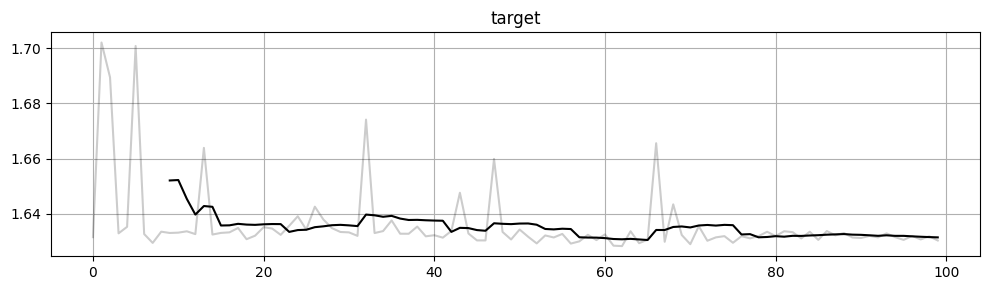

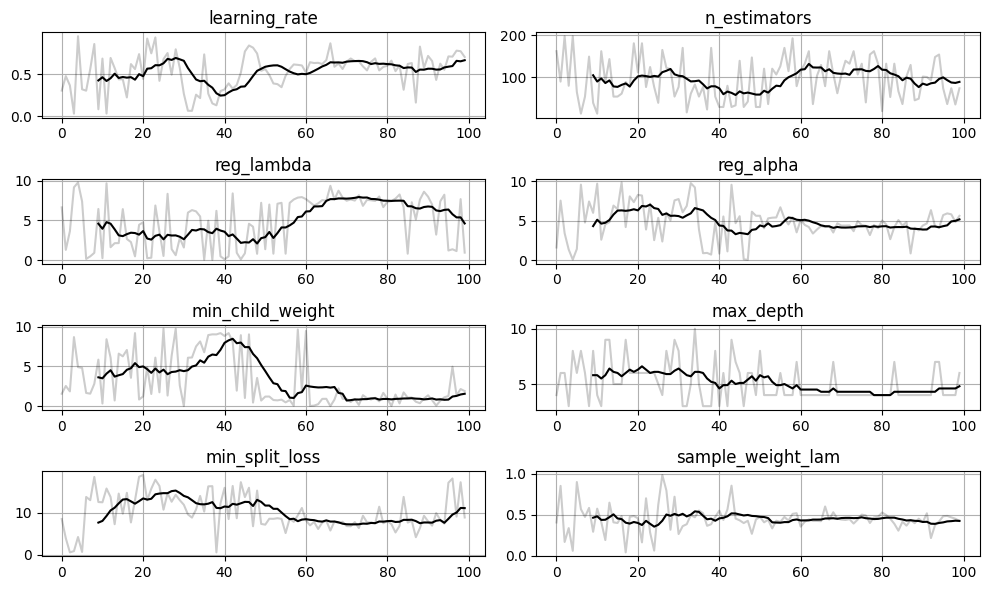

In [6]:
import matplotlib.pyplot as plt


def plot_data(ax, df, c):
    ax.plot(df.index, df[c], color="black", alpha=0.2)
    ax.plot(df.index, df[c].rolling(10).mean(), color="black")
    ax.title.set_text(c)
    ax.grid()


df = pd.DataFrame(experiment.logs)
df = pd.concat([df, df.params.apply(pd.Series)], axis=1)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plot_data(axs, df, "target")
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(len(SPACE) // 2, 2, figsize=(10, 6))
for ax, c in zip(axs.reshape(-1), SPACE):
    plot_data(ax, df, c)

fig.tight_layout()
plt.show()


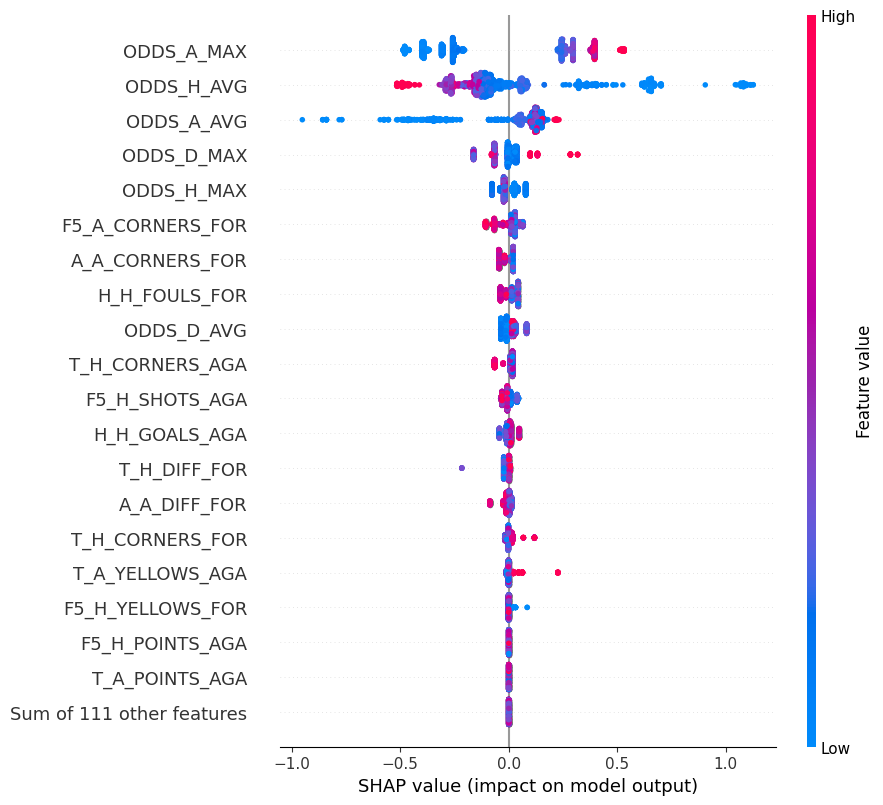

In [7]:
import shap


X_valid, y_valid = split_features_target(valid)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_valid)
shap.plots.beeswarm(shap_values, max_display=20)